In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from tqdm import tqdm

In [2]:
rul = pd.read_csv("data/RUL_FD001.txt", header=None).values.reshape(-1)
df_train = pd.read_csv("data/train_FD001.txt", sep=' ', header=None)
df_train = df_train.drop(df_train.columns[-2:], axis=1)
df_test = pd.read_csv("data/test_FD001.txt", sep=' ', header=None)
df_test = df_test.drop(df_test.columns[-2:], axis=1)

In [3]:
column_selected = df_train[df_train.iloc[:, 0] == 1].std() > 1e-10
column_selected[0:5] = True

In [4]:
df_train = df_train.loc[:, column_selected]
df_test = df_test.loc[:, column_selected]

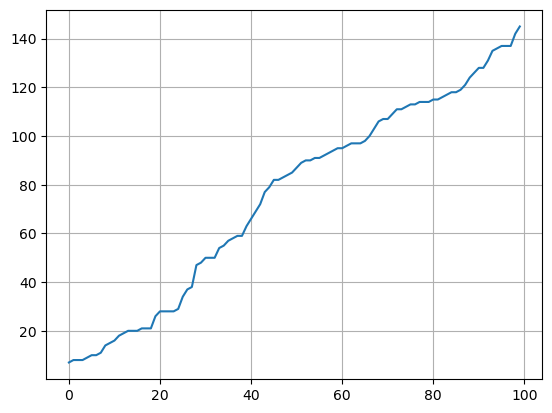

In [5]:
plt.plot(np.sort(rul))
plt.grid()

In [6]:
scaler = MinMaxScaler(feature_range=(-1, 1))
data_train = scaler.fit_transform(df_train.iloc[:, 5:])
data_test = scaler.fit_transform(df_test.iloc[:, 5:])

In [7]:
window_size = 30
y_cap = 130
train_X = []
train_no = []
train_label = []

for i in range(1, 101):
    data_unit = data_train[df_train.iloc[:, 0] == i]
    train_X_unit = []
    train_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        train_X_unit.append(X_pad)
        train_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        train_X_unit.append(data_unit[j:j+window_size, :])
        train_no_unit.append(i)

    rul_unit = len(data_unit)
    y_unit = np.arange(rul_unit, 0, -1) - 1
    y_unit[y_unit>y_cap] = y_cap

    train_X += train_X_unit[:rul_unit]
    train_no += train_no_unit[:rul_unit]

    train_label += list(y_unit)

    #print((i, len(train_label), len(train_X), rul_unit, len(data_unit)))

train_X = torch.tensor(np.array(train_X), dtype=torch.float32)
train_label = torch.tensor(np.array(train_label), dtype=torch.float32)
train_no = torch.tensor(np.array(train_no), dtype=torch.int32)

In [8]:
train_X.shape

torch.Size([20631, 30, 14])

In [9]:
train_label.shape

torch.Size([20631])

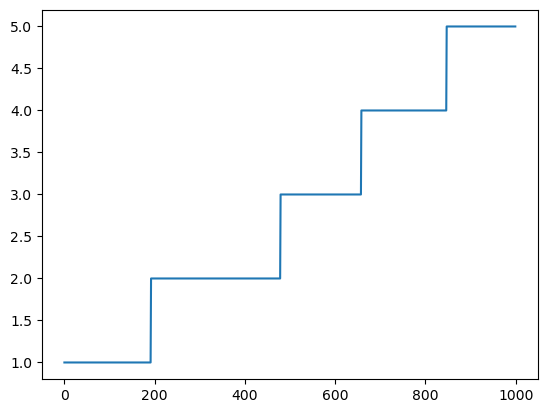

In [10]:
plt.plot(train_no[:1000])

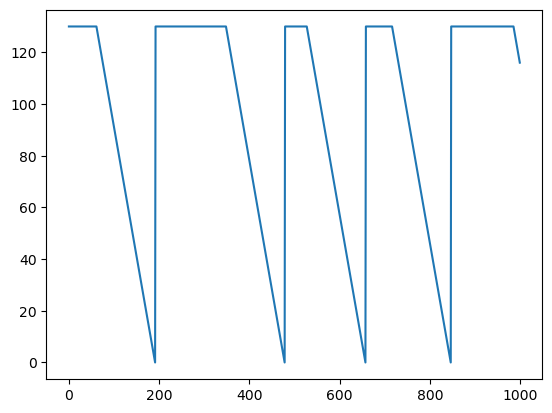

In [11]:
plt.plot(train_label[:1000])

In [12]:
# window_size = 30
# y_cap = 130
# train_X = []
# train_no = []
# train_label = []

# for i in range(1, 101):
#     data_unit = data_train[df_train.iloc[:, 0] == i]
#     train_X_unit = []
#     train_no_unit = []

#     for j in range(window_size-1):
#         X_pad = np.zeros([window_size, data_unit.shape[-1]])
#         X_pad[-j-1:, :] = data_unit[:j+1, :]
#         train_X_unit.append(X_pad)
#         train_no_unit.append(i)

#     for j in range(len(data_unit)-window_size+1):
#         train_X_unit.append(data_unit[j:j+window_size, :])
#         train_no_unit.append(i)

#     rul_unit = rul[i-1]
#     y_unit = np.arange(rul_unit, 0, -1) - 1
#     y_unit = y_unit[:min(rul_unit, len(data_unit))] # RUL of No.39 is larger than duration
#     y_unit[y_unit>y_cap] = y_cap

#     train_X += train_X_unit[:rul_unit]
#     train_no += train_no_unit[:rul_unit]

#     train_label += list(y_unit)

#     #print((i, len(train_label), len(train_X), rul_unit, len(data_unit)))

# train_X = torch.tensor(np.array(train_X), dtype=torch.float32)
# train_label = torch.tensor(np.array(train_label), dtype=torch.float32)
# train_no = torch.tensor(np.array(train_no), dtype=torch.int32)

In [13]:
measure_len = []
for i in range(1, 101):
    data_unit = data_test[df_test.iloc[:, 0] == i]
    measure_len.append(len(data_unit)<rul[i-1])
    print(len(data_unit), rul[i-1])
    
measure_len = np.array(measure_len)

31 112
49 98
126 69
106 82
98 91
105 93
160 91
166 95
55 111
192 96
83 97
217 124
195 95
46 107
76 83
113 84
165 50
133 28
135 87
184 16
148 57
39 111
130 113
186 20
48 145
76 119
140 66
158 97
171 90
143 115
196 8
145 48
50 106
203 7
198 11
126 19
121 21
125 50
37 142
133 28
123 18
156 10
172 59
54 109
152 114
146 47
73 135
78 92
303 21
74 79
144 114
189 29
164 26
121 97
113 137
136 15
160 103
176 37
94 114
147 100
159 21
232 54
155 72
168 28
71 128
147 14
71 77
187 8
54 121
152 94
68 118
131 50
112 131
137 126
88 113
205 10
162 34
72 107
101 63
133 90
213 8
162 9
73 137
172 58
34 118
110 89
56 116
68 115
177 136
146 28
234 38
150 20
244 85
133 55
89 128
97 137
134 82
121 59
97 117
198 20


In [14]:
test_X = []
test_label = []
test_no = []

for i in range(1, 101):
    data_unit = data_test[df_test.iloc[:, 0] == i]
    test_X_unit = []
    test_no_unit = []

    for j in range(window_size-1):
        X_pad = np.zeros([window_size, data_unit.shape[-1]])
        X_pad[-j-1:, :] = data_unit[:j+1, :]
        test_X_unit.append(X_pad)
        test_no_unit.append(i)

    for j in range(len(data_unit)-window_size+1):
        test_X_unit.append(data_unit[j:j+window_size, :])
        test_no_unit.append(i)

    rul_unit = rul[i-1]
    y_unit = np.arange(rul_unit, rul_unit - len(data_unit), -1) - 1
    y_unit[y_unit>y_cap] = y_cap
    y_unit[y_unit<0.] = 0.
    
    if len(test_X_unit) != len(y_unit):
        print((len(test_X_unit), len(y_unit)))

    test_X += test_X_unit
    test_no += test_no_unit
    test_label += list(y_unit)

test_X = torch.tensor(np.array(test_X), dtype=torch.float32)
test_label = torch.tensor(np.array(test_label), dtype=torch.float32)
test_no = torch.tensor(np.array(test_no), dtype=torch.int32)

In [15]:
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, output_dim)
        self.act = nn.Tanh()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.act(x)
        x = self.fc2(x)
        x = self.act(x)
        x = self.fc3(x)
        return x.reshape(-1)

In [16]:
input_dim = 30 * 14
hidden_dim = 128
output_dim = 1
model = MLP(input_dim, hidden_dim, output_dim)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
batch_size = 64

train_dataset = TensorDataset(train_X, train_label)
test_dataset = TensorDataset(test_X, test_label)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [18]:
num_epochs = 200
for epoch in tqdm(range(num_epochs)):
    model.train()
    
    for i, (inputs, labels) in enumerate(train_loader):
        # 前向传播
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch + 1) % 10 == 0 and (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

print("训练结束")

  2%|▏         | 9/500 [00:07<06:36,  1.24it/s]

Epoch [10/500], Step [100/323], Loss: 223.6743
Epoch [10/500], Step [200/323], Loss: 160.4504


  2%|▏         | 10/500 [00:08<06:33,  1.25it/s]

Epoch [10/500], Step [300/323], Loss: 113.3503


  4%|▍         | 19/500 [00:15<07:15,  1.10it/s]

Epoch [20/500], Step [100/323], Loss: 110.9671
Epoch [20/500], Step [200/323], Loss: 98.6847


  4%|▍         | 20/500 [00:17<07:40,  1.04it/s]

Epoch [20/500], Step [300/323], Loss: 159.7651


  6%|▌         | 29/500 [00:25<07:12,  1.09it/s]

Epoch [30/500], Step [100/323], Loss: 91.6314
Epoch [30/500], Step [200/323], Loss: 152.6781


  6%|▌         | 30/500 [00:26<07:04,  1.11it/s]

Epoch [30/500], Step [300/323], Loss: 124.1541


  8%|▊         | 39/500 [00:34<07:30,  1.02it/s]

Epoch [40/500], Step [100/323], Loss: 120.8642
Epoch [40/500], Step [200/323], Loss: 92.9361


  8%|▊         | 40/500 [00:35<07:26,  1.03it/s]

Epoch [40/500], Step [300/323], Loss: 58.0134


 10%|▉         | 49/500 [00:43<06:27,  1.16it/s]

Epoch [50/500], Step [100/323], Loss: 43.1930
Epoch [50/500], Step [200/323], Loss: 75.8935


 10%|█         | 50/500 [00:43<06:24,  1.17it/s]

Epoch [50/500], Step [300/323], Loss: 37.3947


 12%|█▏        | 59/500 [00:51<06:25,  1.15it/s]

Epoch [60/500], Step [100/323], Loss: 75.0871
Epoch [60/500], Step [200/323], Loss: 53.6520


 12%|█▏        | 60/500 [00:52<06:20,  1.15it/s]

Epoch [60/500], Step [300/323], Loss: 58.9630


 14%|█▍        | 69/500 [01:00<05:59,  1.20it/s]

Epoch [70/500], Step [100/323], Loss: 51.6792
Epoch [70/500], Step [200/323], Loss: 24.9693


 14%|█▍        | 70/500 [01:01<06:00,  1.19it/s]

Epoch [70/500], Step [300/323], Loss: 40.1172


 16%|█▌        | 79/500 [01:10<07:21,  1.05s/it]

Epoch [80/500], Step [100/323], Loss: 20.1798
Epoch [80/500], Step [200/323], Loss: 33.5956


 16%|█▌        | 80/500 [01:11<07:21,  1.05s/it]

Epoch [80/500], Step [300/323], Loss: 20.5650


 18%|█▊        | 89/500 [01:19<06:32,  1.05it/s]

Epoch [90/500], Step [100/323], Loss: 12.4707
Epoch [90/500], Step [200/323], Loss: 19.5958


 18%|█▊        | 90/500 [01:21<06:58,  1.02s/it]

Epoch [90/500], Step [300/323], Loss: 16.9595


 20%|█▉        | 99/500 [01:28<05:54,  1.13it/s]

Epoch [100/500], Step [100/323], Loss: 17.3780
Epoch [100/500], Step [200/323], Loss: 22.8780


 20%|██        | 100/500 [01:29<05:43,  1.16it/s]

Epoch [100/500], Step [300/323], Loss: 11.7344


 22%|██▏       | 109/500 [01:37<05:58,  1.09it/s]

Epoch [110/500], Step [100/323], Loss: 9.4220
Epoch [110/500], Step [200/323], Loss: 8.4688


 22%|██▏       | 110/500 [01:38<05:53,  1.10it/s]

Epoch [110/500], Step [300/323], Loss: 7.3881


 24%|██▍       | 119/500 [01:45<05:23,  1.18it/s]

Epoch [120/500], Step [100/323], Loss: 3.6275
Epoch [120/500], Step [200/323], Loss: 3.7166


 24%|██▍       | 120/500 [01:46<05:33,  1.14it/s]

Epoch [120/500], Step [300/323], Loss: 8.7021


 26%|██▌       | 129/500 [01:54<05:32,  1.12it/s]

Epoch [130/500], Step [100/323], Loss: 4.1719
Epoch [130/500], Step [200/323], Loss: 5.8150


 26%|██▌       | 130/500 [01:55<05:28,  1.13it/s]

Epoch [130/500], Step [300/323], Loss: 5.8172


 28%|██▊       | 139/500 [02:03<04:58,  1.21it/s]

Epoch [140/500], Step [100/323], Loss: 2.7575
Epoch [140/500], Step [200/323], Loss: 3.5441


 28%|██▊       | 140/500 [02:04<05:01,  1.20it/s]

Epoch [140/500], Step [300/323], Loss: 3.7905


 30%|██▉       | 149/500 [02:12<05:29,  1.06it/s]

Epoch [150/500], Step [100/323], Loss: 3.1285
Epoch [150/500], Step [200/323], Loss: 2.9876


 30%|███       | 150/500 [02:13<05:23,  1.08it/s]

Epoch [150/500], Step [300/323], Loss: 3.3874


 32%|███▏      | 159/500 [02:20<04:21,  1.30it/s]

Epoch [160/500], Step [100/323], Loss: 1.4400
Epoch [160/500], Step [200/323], Loss: 3.7217


 32%|███▏      | 160/500 [02:20<04:13,  1.34it/s]

Epoch [160/500], Step [300/323], Loss: 2.3070


 34%|███▍      | 169/500 [02:28<04:19,  1.27it/s]

Epoch [170/500], Step [100/323], Loss: 2.9576
Epoch [170/500], Step [200/323], Loss: 1.5097


 34%|███▍      | 170/500 [02:29<04:27,  1.23it/s]

Epoch [170/500], Step [300/323], Loss: 3.9189


 36%|███▌      | 179/500 [02:35<03:54,  1.37it/s]

Epoch [180/500], Step [100/323], Loss: 1.6834
Epoch [180/500], Step [200/323], Loss: 2.1938


 36%|███▌      | 180/500 [02:36<04:11,  1.27it/s]

Epoch [180/500], Step [300/323], Loss: 3.8481


 38%|███▊      | 189/500 [02:44<04:00,  1.29it/s]

Epoch [190/500], Step [100/323], Loss: 2.5329
Epoch [190/500], Step [200/323], Loss: 2.6306


 38%|███▊      | 190/500 [02:44<03:56,  1.31it/s]

Epoch [190/500], Step [300/323], Loss: 1.1745


 40%|███▉      | 199/500 [02:51<03:32,  1.42it/s]

Epoch [200/500], Step [100/323], Loss: 1.7026
Epoch [200/500], Step [200/323], Loss: 2.0593


 40%|████      | 200/500 [02:51<03:28,  1.44it/s]

Epoch [200/500], Step [300/323], Loss: 1.0751


 42%|████▏     | 209/500 [02:58<03:38,  1.33it/s]

Epoch [210/500], Step [100/323], Loss: 2.3948
Epoch [210/500], Step [200/323], Loss: 3.9537


 42%|████▏     | 210/500 [02:59<03:39,  1.32it/s]

Epoch [210/500], Step [300/323], Loss: 1.8780


 44%|████▍     | 219/500 [03:06<03:26,  1.36it/s]

Epoch [220/500], Step [100/323], Loss: 2.5785
Epoch [220/500], Step [200/323], Loss: 2.0494


 44%|████▍     | 220/500 [03:06<03:28,  1.34it/s]

Epoch [220/500], Step [300/323], Loss: 1.3003


 46%|████▌     | 229/500 [03:13<03:27,  1.30it/s]

Epoch [230/500], Step [100/323], Loss: 0.8977
Epoch [230/500], Step [200/323], Loss: 1.0127


 46%|████▌     | 230/500 [03:14<03:22,  1.33it/s]

Epoch [230/500], Step [300/323], Loss: 1.1996


 48%|████▊     | 239/500 [03:22<03:50,  1.13it/s]

Epoch [240/500], Step [100/323], Loss: 3.1266
Epoch [240/500], Step [200/323], Loss: 3.8134
Epoch [240/500], Step [300/323], Loss: 1.3984


 50%|████▉     | 249/500 [03:30<03:17,  1.27it/s]

Epoch [250/500], Step [100/323], Loss: 0.9755
Epoch [250/500], Step [200/323], Loss: 2.1087


 50%|█████     | 250/500 [03:31<03:14,  1.29it/s]

Epoch [250/500], Step [300/323], Loss: 1.3272


 52%|█████▏    | 259/500 [03:37<02:52,  1.40it/s]

Epoch [260/500], Step [100/323], Loss: 1.7643
Epoch [260/500], Step [200/323], Loss: 2.0240


 52%|█████▏    | 260/500 [03:38<02:56,  1.36it/s]

Epoch [260/500], Step [300/323], Loss: 1.1806


 54%|█████▍    | 269/500 [03:45<03:05,  1.25it/s]

Epoch [270/500], Step [100/323], Loss: 1.2395
Epoch [270/500], Step [200/323], Loss: 3.1599


 54%|█████▍    | 270/500 [03:46<02:58,  1.29it/s]

Epoch [270/500], Step [300/323], Loss: 1.0274


 56%|█████▌    | 279/500 [03:52<02:40,  1.38it/s]

Epoch [280/500], Step [100/323], Loss: 1.0517
Epoch [280/500], Step [200/323], Loss: 1.6041


 56%|█████▌    | 280/500 [03:53<02:39,  1.38it/s]

Epoch [280/500], Step [300/323], Loss: 1.1851


 58%|█████▊    | 289/500 [04:00<02:48,  1.25it/s]

Epoch [290/500], Step [100/323], Loss: 1.1661
Epoch [290/500], Step [200/323], Loss: 1.4697


 58%|█████▊    | 290/500 [04:01<02:47,  1.25it/s]

Epoch [290/500], Step [300/323], Loss: 1.4963


 60%|█████▉    | 299/500 [04:07<02:25,  1.38it/s]

Epoch [300/500], Step [100/323], Loss: 1.0937
Epoch [300/500], Step [200/323], Loss: 5.7183


 60%|██████    | 300/500 [04:08<02:24,  1.38it/s]

Epoch [300/500], Step [300/323], Loss: 2.1145


 62%|██████▏   | 309/500 [04:14<02:21,  1.35it/s]

Epoch [310/500], Step [100/323], Loss: 2.5196
Epoch [310/500], Step [200/323], Loss: 0.9165


 62%|██████▏   | 310/500 [04:15<02:25,  1.31it/s]

Epoch [310/500], Step [300/323], Loss: 13.1649


 64%|██████▍   | 319/500 [04:22<02:13,  1.35it/s]

Epoch [320/500], Step [100/323], Loss: 0.7458
Epoch [320/500], Step [200/323], Loss: 0.7535


 64%|██████▍   | 320/500 [04:23<02:14,  1.34it/s]

Epoch [320/500], Step [300/323], Loss: 2.3336


 66%|██████▌   | 329/500 [04:29<02:05,  1.36it/s]

Epoch [330/500], Step [100/323], Loss: 1.1415
Epoch [330/500], Step [200/323], Loss: 0.8417


 66%|██████▌   | 330/500 [04:30<02:13,  1.28it/s]

Epoch [330/500], Step [300/323], Loss: 0.7742


 68%|██████▊   | 339/500 [04:37<01:57,  1.37it/s]

Epoch [340/500], Step [100/323], Loss: 0.9202
Epoch [340/500], Step [200/323], Loss: 1.3968


 68%|██████▊   | 340/500 [04:38<01:57,  1.37it/s]

Epoch [340/500], Step [300/323], Loss: 1.2558


 70%|██████▉   | 349/500 [04:45<01:54,  1.32it/s]

Epoch [350/500], Step [100/323], Loss: 1.0437
Epoch [350/500], Step [200/323], Loss: 0.9064


 70%|███████   | 350/500 [04:45<01:51,  1.35it/s]

Epoch [350/500], Step [300/323], Loss: 2.3573


 72%|███████▏  | 359/500 [04:52<01:41,  1.39it/s]

Epoch [360/500], Step [100/323], Loss: 1.4222
Epoch [360/500], Step [200/323], Loss: 3.5778
Epoch [360/500], Step [300/323], Loss: 1.0315


 74%|███████▍  | 369/500 [05:00<01:33,  1.40it/s]

Epoch [370/500], Step [100/323], Loss: 1.3676
Epoch [370/500], Step [200/323], Loss: 0.5708


 74%|███████▍  | 370/500 [05:00<01:32,  1.41it/s]

Epoch [370/500], Step [300/323], Loss: 0.8446


 76%|███████▌  | 379/500 [05:07<01:31,  1.33it/s]

Epoch [380/500], Step [100/323], Loss: 1.8155
Epoch [380/500], Step [200/323], Loss: 0.7545
Epoch [380/500], Step [300/323], Loss: 2.4270


 78%|███████▊  | 389/500 [05:15<01:28,  1.26it/s]

Epoch [390/500], Step [100/323], Loss: 0.8420
Epoch [390/500], Step [200/323], Loss: 0.5718


 78%|███████▊  | 390/500 [05:16<01:30,  1.21it/s]

Epoch [390/500], Step [300/323], Loss: 1.1758


 80%|███████▉  | 399/500 [05:24<01:30,  1.12it/s]

Epoch [400/500], Step [100/323], Loss: 1.4885
Epoch [400/500], Step [200/323], Loss: 0.9689


 80%|████████  | 400/500 [05:25<01:27,  1.15it/s]

Epoch [400/500], Step [300/323], Loss: 1.2682


 82%|████████▏ | 409/500 [05:33<01:21,  1.12it/s]

Epoch [410/500], Step [100/323], Loss: 0.8829
Epoch [410/500], Step [200/323], Loss: 0.5175


 82%|████████▏ | 410/500 [05:33<01:21,  1.10it/s]

Epoch [410/500], Step [300/323], Loss: 1.0857


 84%|████████▍ | 419/500 [05:42<01:12,  1.12it/s]

Epoch [420/500], Step [100/323], Loss: 1.1462
Epoch [420/500], Step [200/323], Loss: 0.7690


 84%|████████▍ | 420/500 [05:43<01:09,  1.15it/s]

Epoch [420/500], Step [300/323], Loss: 0.7168


 86%|████████▌ | 429/500 [05:51<01:00,  1.17it/s]

Epoch [430/500], Step [100/323], Loss: 0.5542
Epoch [430/500], Step [200/323], Loss: 0.8572


 86%|████████▌ | 430/500 [05:52<01:01,  1.14it/s]

Epoch [430/500], Step [300/323], Loss: 0.5958


 88%|████████▊ | 439/500 [05:59<00:50,  1.21it/s]

Epoch [440/500], Step [100/323], Loss: 0.7818
Epoch [440/500], Step [200/323], Loss: 1.8569


 88%|████████▊ | 440/500 [06:00<00:50,  1.20it/s]

Epoch [440/500], Step [300/323], Loss: 0.4747


 90%|████████▉ | 449/500 [06:08<00:45,  1.12it/s]

Epoch [450/500], Step [100/323], Loss: 1.4107
Epoch [450/500], Step [200/323], Loss: 1.0868


 90%|█████████ | 450/500 [06:09<00:45,  1.09it/s]

Epoch [450/500], Step [300/323], Loss: 0.4947


 92%|█████████▏| 459/500 [06:16<00:33,  1.21it/s]

Epoch [460/500], Step [100/323], Loss: 1.1029
Epoch [460/500], Step [200/323], Loss: 1.1940


 92%|█████████▏| 460/500 [06:17<00:33,  1.21it/s]

Epoch [460/500], Step [300/323], Loss: 1.7350


 94%|█████████▍| 469/500 [06:26<00:31,  1.00s/it]

Epoch [470/500], Step [100/323], Loss: 0.5783
Epoch [470/500], Step [200/323], Loss: 1.1668


 94%|█████████▍| 470/500 [06:26<00:28,  1.06it/s]

Epoch [470/500], Step [300/323], Loss: 0.8864


 96%|█████████▌| 479/500 [06:34<00:17,  1.23it/s]

Epoch [480/500], Step [100/323], Loss: 0.9831
Epoch [480/500], Step [200/323], Loss: 2.0938


 96%|█████████▌| 480/500 [06:34<00:16,  1.22it/s]

Epoch [480/500], Step [300/323], Loss: 0.6220


 98%|█████████▊| 489/500 [06:42<00:09,  1.17it/s]

Epoch [490/500], Step [100/323], Loss: 0.7743
Epoch [490/500], Step [200/323], Loss: 2.2356


 98%|█████████▊| 490/500 [06:43<00:08,  1.18it/s]

Epoch [490/500], Step [300/323], Loss: 0.6025


100%|█████████▉| 499/500 [06:51<00:00,  1.22it/s]

Epoch [500/500], Step [100/323], Loss: 0.6271
Epoch [500/500], Step [200/323], Loss: 0.5095


100%|██████████| 500/500 [06:51<00:00,  1.21it/s]

Epoch [500/500], Step [300/323], Loss: 0.5717
训练结束


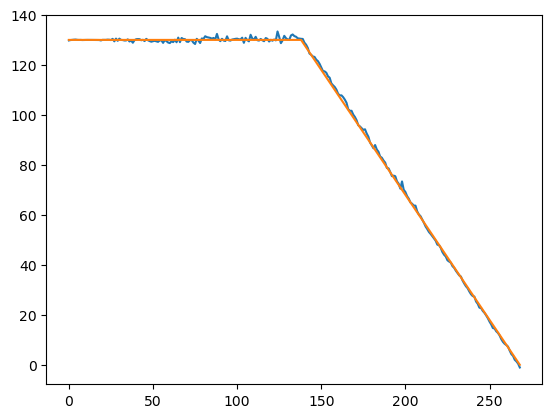

In [21]:
model.eval()
pred = model(train_X[train_no==5]).detach().numpy()
plt.plot(pred)
plt.plot(train_label[train_no==5])

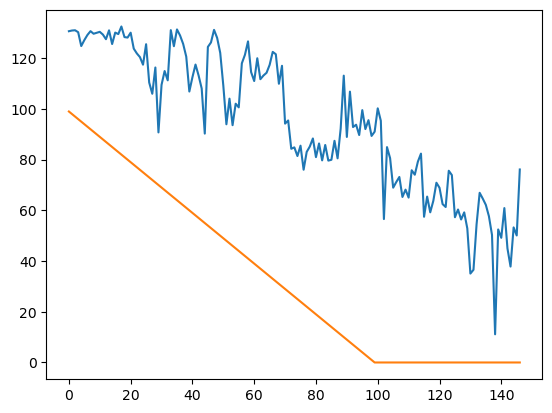

In [23]:
model.eval()
pred = model(test_X[test_no==0]).detach().numpy()
plt.plot(pred)
plt.plot(test_label[test_no==0])